<a href="https://colab.research.google.com/github/hargurjeet/MachineLearning/blob/master/Used_Car_Quality_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Car Quality Detection by XBboost and Random Forests**

Machine learning is the science of getting computers to act without being explicitly programmed. In the past decade, machine learning has given us self-driving cars, practical speech recognition, effective web search, and a vastly improved understanding of the human genome. Machine learning is so pervasive today that you probably use it dozens of times a day without knowing it. In this notebook I implement two of the most known machine learning algorthim to predict the quality of a car.

# **Table Of Contents**<a name="top"></a>


---



---


  1. [About the Dataset](#1)
  2. [Loading the dataset Preprocessing](#2)
  3. [Expainatory Data Analysis](#3)
  4. [Feature Engineering](#4)
  5. [Data Cleaning and Pipelines Implementation](#5)
  6. [Implemneting Random Forest](#6)
  7. [Hyperparameterization - Random Forest](#7)
  8. [Implemneting XBboost Forest](#8)
  9. [Sample Prediction and saving the model](#9)
  10. [Summary](#10)
  11. [Future Work](#11)
  12. [References](#12)

# 1: AboutDataset <a name="1"></a>


---
<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a> 

One of the biggest challenges of an auto dealership purchasing a used car at an auto auction is the risk of that the vehicle might have serious issues that prevent it from being sold to customers. The auto community calls these unfortunate purchases "kicks".

Kicked cars often result when there are tampered odometers, mechanical issues the dealer is not able to address, issues with getting the vehicle title from the seller, or some other unforeseen problem. Kick cars can be very costly to dealers after transportation cost, throw-away repair work, and market losses in reselling the vehicle.

Modelers who can figure out which cars have a higher risk of being kick can provide real value to dealerships trying to provide the best inventory selection possible to their customers.

The challenge of this competition is to predict if the car purchased at the Auction is a Kick (bad buy).

- The challenge of this competition is to predict if the car purchased at the Auction is a good / bad buy.
- All the variables in the data set are defined in the file Carvana_Data_Dictionary.txt 
- The data contains missing values 
- The dependent variable (IsBadBuy) is binary (C2)
- There are 32 Independent variables (C3-C34)
- The data set is split to 60% training and 40% testing.

# 2: Loading the dataset Preprocessing <a name="2"></a>


---
<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a> 

Downloading all the required python packages to get started, also imported all the required libraries

In [1]:
!pip install numpy pandas matplotlib seaborn --quiet
!pip install jovian opendatasets xgboost graphviz lightgbm scikit-learn xgboost lightgbm --upgrade --quiet

     |████████████████████████████████| 68 kB 2.8 MB/s 
     |████████████████████████████████| 166.7 MB 8.5 kB/s 
     |████████████████████████████████| 2.0 MB 35.9 MB/s 
     |████████████████████████████████| 22.3 MB 1.4 MB/s 


In [2]:
#importing dataset
import os
import opendatasets as od
import pandas as pd
import numpy as np

#Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

#For Missing Value and Feature Engineering
from sklearn.feature_selection import SelectKBest, chi2, f_classif, VarianceThreshold
from sklearn.impute import SimpleImputer, KNNImputer, MissingIndicator
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

import time

#for visualization
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 120)
pd.set_option("display.max_rows", 120)

To download the dataset from Kaggle, I use the library **od**.

To connect to kaggle enter user Kaggle username name and API key. 

Please read though this article to understand the process of getting your API key from kaggle.

https://www.analyticsvidhya.com/blog/2021/04/how-to-download-kaggle-datasets-using-jupyter-notebook/

In [3]:
od.download('https://www.kaggle.com/c/DontGetKicked/data?select=test.csv')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: hargurjeet
Your Kaggle Key: ··········


100%|██████████| 10.2M/10.2M [00:00<00:00, 67.1MB/s]


Extracting archive ./DontGetKicked/DontGetKicked.zip to ./DontGetKicked


Below are the list of files downloaded. You can access all the downloaded filename using os.listdir(<'downloaded folder name'>)

In [4]:
os.listdir('DontGetKicked')

['training.csv',
 'test.csv',
 'example_entry.csv',
 'test.zip',
 'Carvana_Data_Dictionary.txt',
 'training.zip']

I use pandas to read the train and test data sets. Here I access few records of training dataset

In [5]:
train=pd.read_csv('/content/DontGetKicked/training.csv') 
test= pd.read_csv('/content/DontGetKicked/test.csv')
train.head()

RefId  IsBadBuy  PurchDate Auction  VehYear  VehicleAge   Make  \
0      1         0  12/7/2009   ADESA     2006           3  MAZDA   
1      2         0  12/7/2009   ADESA     2004           5  DODGE   
2      3         0  12/7/2009   ADESA     2005           4  DODGE   
3      4         0  12/7/2009   ADESA     2004           5  DODGE   
4      5         0  12/7/2009   ADESA     2005           4   FORD   

                 Model Trim           SubModel   Color Transmission  \
0               MAZDA3    i         4D SEDAN I     RED         AUTO   
1  1500 RAM PICKUP 2WD   ST  QUAD CAB 4.7L SLT   WHITE         AUTO   
2           STRATUS V6  SXT   4D SEDAN SXT FFV  MAROON         AUTO   
3                 NEON  SXT           4D SEDAN  SILVER         AUTO   
4                FOCUS  ZX3       2D COUPE ZX3  SILVER       MANUAL   

   WheelTypeID WheelType  VehOdo  Nationality         Size  \
0          1.0     Alloy   89046  OTHER ASIAN       MEDIUM   
1          1.0     Alloy   93593     AMERICAN  LARGE TRUCK   
2          2.0    Covers   73807     AMERICAN       MEDIUM   
3          1.0     Alloy   65617     AMERICAN      COMPACT   
4          2.0    Covers   69367     AMERICAN      COMPACT   

  TopThreeAmericanName  MMRAcquisitionAuctionAveragePrice  \
0                OTHER                             8155.0   
1             CHRYSLER                             6854.0   
2             CHRYSLER                             3202.0   
3             CHRYSLER                             1893.0   
4                 FORD                             3913.0   

   MMRAcquisitionAuctionCleanPrice  MMRAcquisitionRetailAveragePrice  \
0                           9829.0                           11636.0   
1                           8383.0                           10897.0   
2                           4760.0                            6943.0   
3                           2675.0                            4658.0   
4                           5054.0                            7723.0   

   MMRAcquisitonRetailCleanPrice  MMRCurrentAuctionAveragePrice  \
0                        13600.0                         7451.0   
1                        12572.0                         7456.0   
2                         8457.0                         4035.0   
3                         5690.0                         1844.0   
4                         8707.0                         3247.0   

   MMRCurrentAuctionCleanPrice  MMRCurrentRetailAveragePrice  \
0                       8552.0                       11597.0   
1                       9222.0                       11374.0   
2                       5557.0                        7146.0   
3                       2646.0                        4375.0   
4                       4384.0                        6739.0   

   MMRCurrentRetailCleanPrice PRIMEUNIT AUCGUART  BYRNO  VNZIP1 VNST  \
0                     12409.0       NaN      NaN  21973   33619   FL   
1                     12791.0       NaN      NaN  19638   33619   FL   
2                      8702.0       NaN      NaN  19638   33619   FL   
3                      5518.0       NaN      NaN  19638   33619   FL   
4                      7911.0       NaN      NaN  19638   33619   FL   

   VehBCost  IsOnlineSale  WarrantyCost  
0    7100.0             0          1113  
1    7600.0             0          1053  
2    4900.0             0          1389  
3    4100.0             0           630  
4    4000.0             0          1020

# 3: Expainatory Data Analysis <a name="3"></a>


---
<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a> 

## 3.1: Understanding the manufacture year of the vechicles

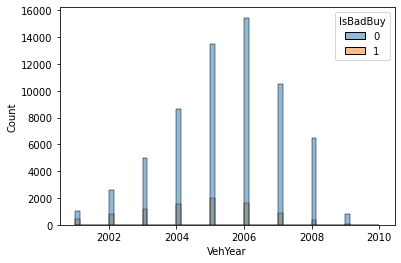

In [6]:
sns.histplot(data=train, x="VehYear", hue='IsBadBuy');

It is evident that although the max vechicles are with manufacturing of 2005 and 2006, the percentage of vechicle turn out to be kicks are less as compared to the manufacturing year 2001 and 2002 where this rate seems to be close to 50%.

Vechile from the later year of 2008 and 2009 seems to have minimum no of vechicle that turn out bad.

## 3.2 Checking if the autction has any influence or vechile being bad.

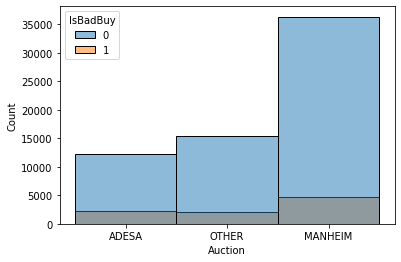

In [7]:
sns.histplot(data=train, x="Auction", hue='IsBadBuy');

It is observed at MANHEIM auction most of the car sold have the turned out good.

## 3.3 Understanding the Manufactures

In [8]:
train.Make.value_counts().head(10)

CHEVROLET    17248
DODGE        12912
FORD         11305
CHRYSLER      8844
PONTIAC       4258
KIA           2484
SATURN        2163
NISSAN        2085
HYUNDAI       1811
JEEP          1644
Name: Make, dtype: int64

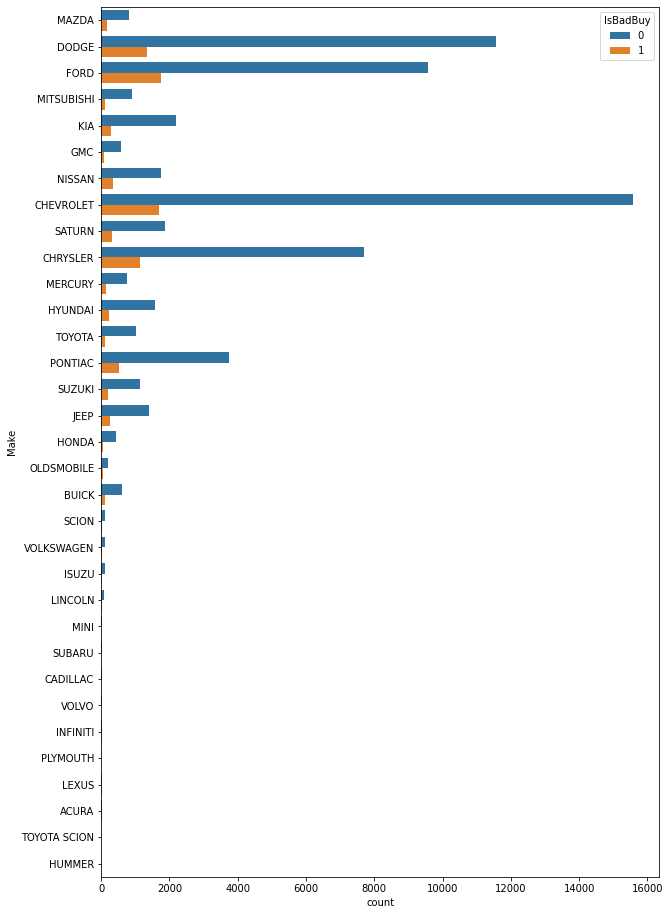

In [9]:
fig, ax = plt.subplots(figsize=(10,16))
sns.countplot(y="Make", data=train, hue='IsBadBuy')
plt.show()

Cars from mnaufacutres DODGE and FORD seems to have maximum no of kicked cars

## 3.4 Impact of color of car being kicked or not

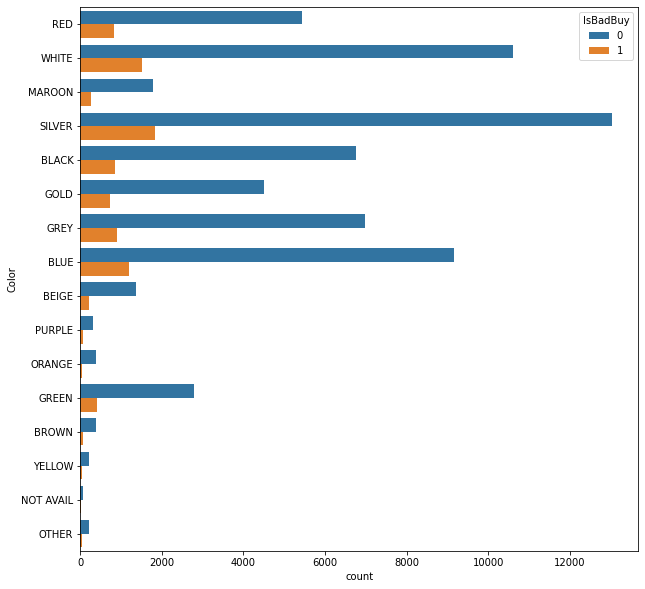

In [15]:
fig, ax = plt.subplots(figsize=(10,10))
sns.countplot(y="Color", data=train, hue='IsBadBuy')
plt.show()

There is a high probablity of repainting of kicked cars. High no of kicked cars are painted in White, Sliver, Blue

## 3.5 Impact of transmission type on kicked cars

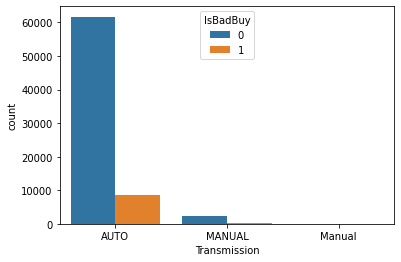

In [18]:
sns.countplot(x="Transmission", data=train, hue='IsBadBuy');

Couple of observations here

- Most of the car have AUTO transmission and kicked cars out of these are about  16%.

- Data quality issue, For some cars transmission type is recorded as 'Manual' instead of 'MANUAL'

# 4: Feature Engineering <a name="4"></a>


---
<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a> 

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72983 entries, 0 to 72982
Data columns (total 34 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   RefId                              72983 non-null  int64  
 1   IsBadBuy                           72983 non-null  int64  
 2   PurchDate                          72983 non-null  object 
 3   Auction                            72983 non-null  object 
 4   VehYear                            72983 non-null  int64  
 5   VehicleAge                         72983 non-null  int64  
 6   Make                               72983 non-null  object 
 7   Model                              72983 non-null  object 
 8   Trim                               70623 non-null  object 
 9   SubModel                           72975 non-null  object 
 10  Color                              72975 non-null  object 
 11  Transmission                       72974 non-null  obj

Before performing the feature engineering, let us first check the data quality and identify null values.

In [ ]:
print(train.isnull().sum())

RefId                                    0
IsBadBuy                                 0
PurchDate                                0
Auction                                  0
VehYear                                  0
VehicleAge                               0
Make                                     0
Model                                    0
Trim                                  2360
SubModel                                 8
Color                                    8
Transmission                             9
WheelTypeID                           3169
WheelType                             3174
VehOdo                                   0
Nationality                              5
Size                                     5
TopThreeAmericanName                     5
MMRAcquisitionAuctionAveragePrice       18
MMRAcquisitionAuctionCleanPrice         18
MMRAcquisitionRetailAveragePrice        18
MMRAcquisitonRetailCleanPrice           18
MMRCurrentAuctionAveragePrice          315
MMRCurrentA

In [ ]:
print(test.isnull().sum())

RefId                                    0
PurchDate                                0
Auction                                  0
VehYear                                  0
VehicleAge                               0
Make                                     0
Model                                    0
Trim                                  1550
SubModel                                 5
Color                                    4
Transmission                             3
WheelTypeID                           2188
WheelType                             2188
VehOdo                                   0
Nationality                              7
Size                                     7
TopThreeAmericanName                     7
MMRAcquisitionAuctionAveragePrice       10
MMRAcquisitionAuctionCleanPrice         10
MMRAcquisitionRetailAveragePrice        10
MMRAcquisitonRetailCleanPrice           10
MMRCurrentAuctionAveragePrice          143
MMRCurrentAuctionCleanPrice            143
MMRCurrentR

**Checking Duplicates**

In [ ]:
train[train.duplicated()]

Empty DataFrame
Columns: [RefId, IsBadBuy, PurchDate, Auction, VehYear, VehicleAge, Make, Model, Trim, SubModel, Color, Transmission, WheelTypeID, WheelType, VehOdo, Nationality, Size, TopThreeAmericanName, MMRAcquisitionAuctionAveragePrice, MMRAcquisitionAuctionCleanPrice, MMRAcquisitionRetailAveragePrice, MMRAcquisitonRetailCleanPrice, MMRCurrentAuctionAveragePrice, MMRCurrentAuctionCleanPrice, MMRCurrentRetailAveragePrice, MMRCurrentRetailCleanPrice, PRIMEUNIT, AUCGUART, BYRNO, VNZIP1, VNST, VehBCost, IsOnlineSale, WarrantyCost]
Index: []

In [ ]:
test[test.duplicated()]

Empty DataFrame
Columns: [RefId, PurchDate, Auction, VehYear, VehicleAge, Make, Model, Trim, SubModel, Color, Transmission, WheelTypeID, WheelType, VehOdo, Nationality, Size, TopThreeAmericanName, MMRAcquisitionAuctionAveragePrice, MMRAcquisitionAuctionCleanPrice, MMRAcquisitionRetailAveragePrice, MMRAcquisitonRetailCleanPrice, MMRCurrentAuctionAveragePrice, MMRCurrentAuctionCleanPrice, MMRCurrentRetailAveragePrice, MMRCurrentRetailCleanPrice, PRIMEUNIT, AUCGUART, BYRNO, VNZIP1, VNST, VehBCost, IsOnlineSale, WarrantyCost]
Index: []

As we see above, many column contains null values. It is important for us to understand the relevant columns that would help model to better generalize.
Hence following columns seems not relevant that are requied to be passed to the model
- PurchDate (Date might not be relevant by Year would be)
- WheelTypeID
- Model
- Trim 
- SubModel
- Make
- VNZIP1
- VNST
- Color

Here I create few addtional column using the existing column to drive some addtional features from the datasets.

The additional features help the model in better training, aslo ensuring the model to be more generalized.

In [ ]:
def split_date(df):
  df['PurchDate'] = pd.to_datetime(df['PurchDate'])
  df['Year'] = df.PurchDate.dt.year

In [ ]:
def MeanOnFeatures(df):
  df['mean_MMRCurrentAuctionAveragePrice_Make']=train.groupby(['Make'])['MMRCurrentAuctionAveragePrice'].transform('mean')
  df['mean_MMRCurrentAuctionAveragePrice_Model']=train.groupby(['Model'])['MMRCurrentAuctionAveragePrice'].transform('mean')
  df['mean_MMRCurrentAuctionAveragePrice_Trim']=train.groupby(['Trim'])['MMRCurrentAuctionAveragePrice'].transform('mean')
  df['mean_MMRCurrentAuctionAveragePrice_SubModel']=train.groupby(['SubModel'])['MMRCurrentAuctionAveragePrice'].transform('mean')
  df['mean_MMRCurrentAuctionAveragePrice_Color']=train.groupby(['Color'])['MMRCurrentAuctionAveragePrice'].transform('mean')
  df['mean_MMRCurrentAuctionAveragePrice_Transmission']=train.groupby(['Transmission'])['MMRCurrentAuctionAveragePrice'].transform('mean')

In [ ]:
print(train.shape, test.shape)

(72983, 34) (48707, 33)


In [ ]:
split_date(train)
split_date(test)

print(train.shape, test.shape)

MeanOnFeatures(train)
MeanOnFeatures(test)

(72983, 35) (48707, 34)


In [ ]:
print(train.shape, test.shape)

(72983, 41) (48707, 40)


In [ ]:
not_relevant_coulmns = ["PurchDate", "WheelTypeID", "Model", "Trim", "SubModel", "VNZIP1", "VNST", "Make", "Color"]

def remove_features(df):
  df.drop(not_relevant_coulmns, axis=1, inplace=True)

remove_features(train)
remove_features(test)

In [ ]:
print(train.shape, test.shape)

(72983, 32) (48707, 31)


**Handling NaN**

In [ ]:
train.isnull().sum()

RefId                                                  0
IsBadBuy                                               0
Auction                                                0
VehYear                                                0
VehicleAge                                             0
Transmission                                           9
WheelType                                           3174
VehOdo                                                 0
Nationality                                            5
Size                                                   5
TopThreeAmericanName                                   5
MMRAcquisitionAuctionAveragePrice                     18
MMRAcquisitionAuctionCleanPrice                       18
MMRAcquisitionRetailAveragePrice                      18
MMRAcquisitonRetailCleanPrice                         18
MMRCurrentAuctionAveragePrice                        315
MMRCurrentAuctionCleanPrice                          315
MMRCurrentRetailAveragePrice   

I observed one particular scenario where the categrical values are varying becuase of the case sensitive issue. 

In [ ]:
train.Transmission.value_counts()

AUTO      70398
MANUAL     2575
Manual        1
Name: Transmission, dtype: int64

In [ ]:
# This should reslove this difference
train["Transmission"].replace("Manual", "MANUAL", inplace=True)

The target values seems to be highly imbalance. This is not good for our machine learning model

In [ ]:
train.IsBadBuy.value_counts()

0    64007
1     8976
Name: IsBadBuy, dtype: int64

1    64007
0    64007
Name: IsBadBuy, dtype: int64


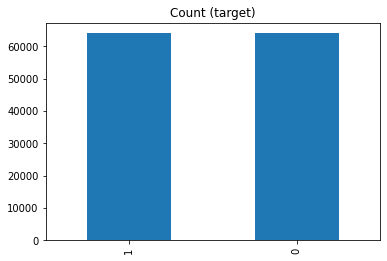

In [ ]:
count_class_0, count_class_1 = train.IsBadBuy.value_counts()

df_class_0 = train[train['IsBadBuy'] == 0]
df_class_1 = train[train['IsBadBuy'] == 1]

df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_test_over = pd.concat([df_class_0, df_class_1_over], axis=0)

print(df_test_over.IsBadBuy.value_counts())

df_test_over.IsBadBuy.value_counts().plot(kind='bar', title='Count (target)');

# 5: Data Cleaning, Spliting and Pipelines Implementation <a name="5"></a>


---
<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a> 

We perform the following tasks under this section
- Segregating the features and target.
- Identifying the numberical and categorical columns.
- Spliting the dataset between train and testing. 
- For numberical columns
  - Used KNN Imputer to fill the missing values.
  - MinMaxScaler() to normalize the numberical values.
- For categorical columns
  - Used Simple Imputer to fill up the missing values.
  - OneHotEncoder to all the catogorical columns.
- Finally all the above steps are put inside a **pipelines**

In [ ]:
#create X and y datasets for splitting 
X = df_test_over.drop(["RefId",'IsBadBuy'], axis=1)
y = df_test_over['IsBadBuy']

In [ ]:
all_features = X.columns
all_features = all_features.tolist()

In [ ]:
numerical_features = [c for c, dtype in zip(X.columns, X.dtypes)
                     if dtype.kind in ['i','f']]
categorical_features = [c for c, dtype in zip(X.columns, X.dtypes)
                     if dtype.kind not in ['i','f']]

In [ ]:
#import train_test_split library
from sklearn.model_selection import train_test_split

# create train test split
X_train, X_test, y_train, y_test = train_test_split(X,  y, test_size=0.3, random_state=42) 

In [ ]:
preprocessor = make_column_transformer(
    
    (make_pipeline(
    SimpleImputer(strategy = 'median'),
    # KNNImputer(n_neighbors=2, weights="uniform"),
    MinMaxScaler()), numerical_features),
    
    (make_pipeline(
    SimpleImputer(strategy = 'constant', fill_value = 'missing'),
    OneHotEncoder(categories = 'auto', handle_unknown = 'ignore')), categorical_features),
    
)

In [ ]:
preprocessor_best = make_pipeline(preprocessor, 
                                  VarianceThreshold(), 
                                  SelectKBest(f_classif, k = 50)
                                 )

# 6: Implemneting Random Forest <a name="6"></a>


---
<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a> 

In [ ]:
RF_Model = make_pipeline(preprocessor_best, RandomForestClassifier(n_estimators = 100))

In [ ]:
RF_Model.fit(X_train, y_train)
RF_Model.score(X_train, y_train)

1.0

The training set accuracy is close to 100%! But we can't rely solely on the training set accuracy, we must evaluate the model on the validation/test set too.

We can make predictions and compute accuracy in one step using model.score

In [ ]:
RF_Model.score(X_test, y_test)

0.9837000390574144

It appears that the model has learned the training examples perfect, and doesn't generalize well to previously unseen examples. One possible reason might be because we to reslove oversampling we ended up inducing some overlaps between testing and training set hence we are observing a very high accuracy. This phenomenon is called "overfitting", and reducing overfitting is one of the most important parts of any machine learning project.

I can now think of two possible solutions
1. hyperparamterization to over come the overfitting. I will cover this in next section.
2. Instead of spliting the data in train and testing set. Let us train on the entire set in one go this valiation strategy is called as K-fold cross validation. To illustrate this via an example I will implement XGboost an apply cross validation on top on it.

# 7: Hyperparamterization and Parameter Tuning  - Random Forest <a name="7"></a>


---
<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a> 

As we saw in the previous section, our random tree classifier memorized all training examples, leading to a 100% training accuracy, while the validation accuracy was only marginally better than a dumb baseline model. This phenomenon is called overfitting, and in this section, we'll look at some strategies for reducing overfitting. The process of reducing overfitting is known as regularlization.


By varying the following fields, we can prevent the tree from memorizing all training examples, which may lead to better generalization

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 19)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
#Maximum number of levels in tree
max_depth = [2,4,6,8]
# Minimum number of samples required to split a node
min_samples_split = [2, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]
# Method of selecting samples for training each tree
bootstrap = [True, False]

In [ ]:
# Create the param grid
param_grid = {'randomforestclassifier__n_estimators': n_estimators,
               'randomforestclassifier__max_features': max_features,
               'randomforestclassifier__max_depth': max_depth,
               'randomforestclassifier__min_samples_split': min_samples_split,
               'randomforestclassifier__min_samples_leaf': min_samples_leaf,
               'randomforestclassifier__bootstrap': bootstrap
             }
print(param_grid)

{'randomforestclassifier__n_estimators': [100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000], 'randomforestclassifier__max_features': ['auto', 'sqrt'], 'randomforestclassifier__max_depth': [2, 4, 6, 8], 'randomforestclassifier__min_samples_split': [2, 5], 'randomforestclassifier__min_samples_leaf': [1, 2], 'randomforestclassifier__bootstrap': [True, False]}


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
rf_RandomGrid = RandomizedSearchCV(estimator = RF_Model, param_distributions = param_grid, cv = 3, verbose=1, n_jobs = -1, n_iter = 5, scoring = 'f1')

In [ ]:
%%time
rf_RandomGrid.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
CPU times: user 1min 8s, sys: 762 ms, total: 1min 9s
Wall time: 8min 22s


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('pipeline',
                                              Pipeline(steps=[('columntransformer',
                                                               ColumnTransformer(transformers=[('pipeline-1',
                                                                                                Pipeline(steps=[('simpleimputer',
                                                                                                                 SimpleImputer(strategy='median')),
                                                                                                                ('minmaxscaler',
                                                                                                                 MinMaxScaler())]),
                                                                                                ['VehYear',
                                                                            

In [ ]:
rf_RandomGrid.score(X_train, y_train)

0.7053987329979504

In [ ]:
rf_RandomGrid.score(X_test, y_test)

0.6956119337979094

Although the accuracy of overall model is reduced, We have significantly reduced overfitting as we see the co relation between the training and testing results. I now pick the best parameters which would help to me to achive better accuray from the avalaible list of parameters. 

Sklearn provides us the library **gridsearch CV** to help us running all the model over the list of parameter instead we doing it manually and **best_estimator** helps us in selecting the best parameter on which the model would befrom best

In [ ]:
rf_RandomGrid.best_estimator_

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(transformers=[('pipeline-1',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer(strategy='median')),
                                                                                   ('minmaxscaler',
                                                                                    MinMaxScaler())]),
                                                                   ['VehYear',
                                                                    'VehicleAge',
                                                                    'VehOdo',
                                                                    'MMRAcquisitionAuctionAveragePrice',
                                                                    

Accuracy

In [ ]:
print(f'Train : {rf_RandomGrid.score(X_train, y_train):.3f}')
print(f'Test : {rf_RandomGrid.score(X_test, y_test):.3f}')

Train : 0.705
Test : 0.696


In [ ]:
X_test.head()

Auction  VehYear  VehicleAge Transmission WheelType  VehOdo  \
66800    ADESA     2006           4         AUTO     Alloy   79425   
60924  MANHEIM     2004           6         AUTO     Alloy   57477   
29350    OTHER     2008           1         AUTO    Covers   51993   
8085   MANHEIM     2003           7         AUTO     Alloy   88192   
56014    OTHER     2005           4         AUTO     Alloy   86397   

          Nationality        Size TopThreeAmericanName  \
66800  TOP LINE ASIAN      MEDIUM                OTHER   
60924        AMERICAN       LARGE                   GM   
29350        AMERICAN      MEDIUM             CHRYSLER   
8085         AMERICAN  MEDIUM SUV                   GM   
56014        AMERICAN   CROSSOVER             CHRYSLER   

       MMRAcquisitionAuctionAveragePrice  MMRAcquisitionAuctionCleanPrice  \
66800                             7217.0                           8690.0   
60924                             4249.0                           5452.0   
29350                             7239.0                           7802.0   
8085                              5419.0                           6817.0   
56014                             6947.0                           8346.0   

       MMRAcquisitionRetailAveragePrice  MMRAcquisitonRetailCleanPrice  \
66800                           10887.0                        12125.0   
60924                            6678.0                         8172.0   
29350                            8318.0                         8926.0   
8085                             9180.0                        10364.0   
56014                            8003.0                         9514.0   

       MMRCurrentAuctionAveragePrice  MMRCurrentAuctionCleanPrice  \
66800                         7813.0                       9250.0   
60924                         4381.0                       5885.0   
29350                         7524.0                       8277.0   
8085                          5946.0                       7408.0   
56014                         6150.0                       7713.0   

       MMRCurrentRetailAveragePrice  MMRCurrentRetailCleanPrice PRIMEUNIT  \
66800                       11633.0                     13264.0       NaN   
60924                        7759.0                      9371.0       NaN   
29350                       10564.0                     11431.0       NaN   
8085                         9684.0                     11810.0       NaN   
56014                        7142.0                      8830.0       NaN   

      AUCGUART  BYRNO  VehBCost  IsOnlineSale  WarrantyCost  Year  \
66800      NaN  17675    7560.0             0           686  2010   
60924      NaN   5546    7020.0             0          1500  2010   
29350      NaN  99761    6800.0             0           754  2009   
8085       NaN  17675    7800.0             0          2452  2010   
56014      NaN  18880    7900.0             0          1503  2009   

       mean_MMRCurrentAuctionAveragePrice_Make  \
66800                              7021.627649   
60924                              6232.051888   
29350                              6546.501242   
8085                               6232.051888   
56014                              6032.147123   

       mean_MMRCurrentAuctionAveragePrice_Model  \
66800                               7091.027900   
60924                               5090.230337   
29350                               7586.763860   
8085                                7290.643939   
56014                               7732.619808   

       mean_MMRCurrentAuctionAveragePrice_Trim  \
66800                              6171.007828   
60924                              6466.957348   
29350                              5768.078539   
8085                               6466.957348   
56014                              5831.287933   

       mean_MMRCurrentAuctionAveragePrice_SubModel  \
66800                                  5577.972891   
60924              

In [ ]:
X_test.iloc[1:2, :]

Auction  VehYear  VehicleAge Transmission WheelType  VehOdo  \
60924  MANHEIM     2004           6         AUTO     Alloy   57477   

      Nationality   Size TopThreeAmericanName  \
60924    AMERICAN  LARGE                   GM   

       MMRAcquisitionAuctionAveragePrice  MMRAcquisitionAuctionCleanPrice  \
60924                             4249.0                           5452.0   

       MMRAcquisitionRetailAveragePrice  MMRAcquisitonRetailCleanPrice  \
60924                            6678.0                         8172.0   

       MMRCurrentAuctionAveragePrice  MMRCurrentAuctionCleanPrice  \
60924                         4381.0                       5885.0   

       MMRCurrentRetailAveragePrice  MMRCurrentRetailCleanPrice PRIMEUNIT  \
60924                        7759.0                      9371.0       NaN   

      AUCGUART  BYRNO  VehBCost  IsOnlineSale  WarrantyCost  Year  \
60924      NaN   5546    7020.0             0          1500  2010   

       mean_MMRCurrentAuctionAveragePrice_Make  \
60924                              6232.051888   

       mean_MMRCurrentAuctionAveragePrice_Model  \
60924                               5090.230337   

       mean_MMRCurrentAuctionAveragePrice_Trim  \
60924                              6466.957348   

       mean_MMRCurrentAuctionAveragePrice_SubModel  \
60924                                  4689.661074   

       mean_MMRCurrentAuctionAveragePrice_Color  \
60924                               6582.068127   

       mean_MMRCurrentAuctionAveragePrice_Transmission  
60924                                      6180.060667

In [ ]:
array = rf_RandomGrid.predict_proba(X_test.iloc[1:2, :])[0]
array[0]

array([0.50157852, 0.49842148])

It is observed that although the accuray has dropped significantly but the deviation between the training and test sets is minimal. Hence our model is fairly generalized.

Results captured can now be submitted to kaggle. In the following block we create the output file and the same can be uploaded to kaggle

In [ ]:
preds = rf_RandomGrid.predict(test.iloc[:, 1:31])
output = pd.DataFrame({'Refid': test.RefId, 'IsBadBuy': preds})
output.to_csv('my_submission_rf_model_hyperparameterized.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


# <font color="white" size=+2.0><b>8: Implementing XBboost Forest</b></font> <a name="8"></a>


---
<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a> 

First we will setup our pipelines as usual

In [ ]:
preprocessor = make_column_transformer(
    
    (make_pipeline(
    #SimpleImputer(strategy = 'median'),
    KNNImputer(n_neighbors=2, weights="uniform"),
    MinMaxScaler()), numerical_features),
    
    (make_pipeline(
    SimpleImputer(strategy = 'constant', fill_value = 'missing'),
    OneHotEncoder(categories = 'auto', handle_unknown = 'ignore')), categorical_features),

)

preprocessor_best = make_pipeline(preprocessor,
                                  VarianceThreshold(), 
                                  SelectKBest(f_classif, k = 50)
                                 )


Here we call the xgboost classifier

In [ ]:
from xgboost import XGBClassifier
import xgboost as xgb
# model = XGBClassifier(random_state=42, n_jobs=-1, n_estimators=20, max_depth=4, use_label_encoder=False)

XG_model = make_pipeline(preprocessor_best, XGBClassifier(n_estimators = 100))

Now we fit the model to the entire dataset. Remember we wont be performing train test split instead we will use K fold cross validation to evaluta our model.

In [ ]:
%%time

# XG_model.fit(X_train, y_train)
XG_model.fit(X, y)

/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:07:51] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: user 2min 3s, sys: 4.45 s, total: 2min 8s
Wall time: 1min 32s


Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(transformers=[('pipeline-1',
                                                                   Pipeline(steps=[('knnimputer',
                                                                                    KNNImputer(n_neighbors=2)),
                                                                                   ('minmaxscaler',
                                                                                    MinMaxScaler())]),
                                                                   ['VehYear',
                                                                    'VehicleAge',
                                                                    'VehOdo',
                                                                    'MMRAcquisitionAuctionAveragePrice',
                                                                    'MMRAcquis

In [ ]:
# XG_model.score(X_train, y_train)
XG_model.score(X, y)

0.8396972206164951

Our model has shown the accuracy of about 83% when tested on train set. Let us now implement the k fold cross validation

**K Fold Cross Validation**

In [ ]:
from sklearn.model_selection import KFold

In [ ]:
def train_and_evaluate(X_train, train_targets, X_val, val_targets, **params):
    model = make_pipeline(preprocessor_best, XGBClassifier(random_state=42, n_jobs=-1, **params))
    model.fit(X_train, train_targets)
    train_accuracy = model.score(X_train, train_targets)
    val_accuracy = model.score(X_val, val_targets)
    return model, train_accuracy, val_accuracy

In [ ]:
kfold = KFold(n_splits=5)

In [ ]:
models = []

for train_idxs, val_idxs in kfold.split(X):
    X_train, train_targets = X.iloc[train_idxs], y.iloc[train_idxs]
    X_val, val_targets = X.iloc[val_idxs], y.iloc[val_idxs]
    model, train_accuracy, val_accuracy = train_and_evaluate(X_train, 
                                                     train_targets, 
                                                     X_val, 
                                                     val_targets, 
                                                     max_depth=4, 
                                                     n_estimators=20)
    models.append(model)
    print('Train Accuracy: {}, Validation Accuracy: {}'.format(train_accuracy, val_accuracy))

/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:14:49] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train Accuracy: 0.7315815683862085, Validation Accuracy: 0.3719876576963637


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:16:16] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train Accuracy: 0.7172081124097998, Validation Accuracy: 0.3719876576963637


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:18:01] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train Accuracy: 0.7171397603773032, Validation Accuracy: 0.4797484669765262


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:19:52] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train Accuracy: 0.7364931501498863, Validation Accuracy: 0.41510760457758855


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:21:49] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train Accuracy: 0.7382533296879272, Validation Accuracy: 0.4253183345051168


Train Accuracy: 0.7321576783743934, Validation Accuracy: 0.3810881537319845

Train Accuracy: 0.7148939078809894, Validation Accuracy: 0.39284458852478227

Train Accuracy: 0.7126871136889592, Validation Accuracy: 0.48498222864508067

Train Accuracy: 0.7391100565368954, Validation Accuracy: 0.43030113658555635

Train Accuracy: 0.7381556848806781, Validation Accuracy: 0.4356690883524725


As observed here although the accuracy of training set is high but validation set seems to exbhit very low accuracy. So none of these model is good enough but we can take avaerage of these model so that the errors are reduced. Let's also define a function to average predictions from the 5 different models.

In [ ]:
import numpy as np

def predict_avg(models, inputs):
    return np.mean([model.predict(inputs) for model in models], axis=0)

Now we predict the test outcome based on the average learning of all above 5 models

In [ ]:
preds = predict_avg(models, test.iloc[:, 1:31])

In [ ]:
for x in range(0, len(preds)):
  if preds[x] <=0.5:
    preds[x] =0
  else:
    preds[x] =1

In [ ]:
preds

array([0., 0., 0., ..., 0., 0., 0.])

In [ ]:
output = pd.DataFrame({'Refid': test.RefId, 'IsBadBuy': preds})
output.to_csv('my_submission_xgboost_crossvalidation.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


# 9: Sample prediction and saving model weights <a name="9"></a>


---
<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a> 

Making Predictions on New Inputs

In [ ]:
def predict_input(model, single_input):
    input_df = pd.DataFrame([single_input])
    pred = rf_RandomGrid.predict(input_df)
    prob = rf_RandomGrid.predict_proba(input_df)[0]
    return pred, prob[0]

In [ ]:
new_input = {'Auction':'ADESA', 
             'VehYear':2004, 
             'VehicleAge':6, 
             'Transmission':'AUTO', 
             'WheelType':'Alloy',
             'VehOdo':33333, 
             'Nationality':'TOP LINE ASIAN', 
             'Size':'MEDIUM',
             'TopThreeAmericanName':'OTHER',
             'MMRAcquisitionAuctionAveragePrice':7777, 
             'MMRAcquisitionAuctionCleanPrice':8888,
             'MMRAcquisitionRetailAveragePrice':10000, 
             'MMRAcquisitonRetailCleanPrice':12000,
             'MMRCurrentAuctionAveragePrice':7777, 
             'MMRCurrentAuctionCleanPrice':9999,
             'MMRCurrentRetailAveragePrice':11111, 
             'MMRCurrentRetailCleanPrice':11111,
             'PRIMEUNIT':'NaN', 
             'AUCGUART':'NaN', 
             'BYRNO':17777, 
             'VehBCost':7777, 
             'IsOnlineSale':0,
             'WarrantyCost':600, 
             'Year':2010, 
             'mean_MMRCurrentAuctionAveragePrice_Make':7021.627649,
             'mean_MMRCurrentAuctionAveragePrice_Model':7091.0279,
             'mean_MMRCurrentAuctionAveragePrice_Trim':6171.007828,
             'mean_MMRCurrentAuctionAveragePrice_SubModel':5577.972891,
             'mean_MMRCurrentAuctionAveragePrice_Color':6794.120395,
             'mean_MMRCurrentAuctionAveragePrice_Transmission':6180.060667}

In [ ]:
predict_input(rf_RandomGrid, new_input)

(array([0]), 0.6374213492228148)

The output of our given sample is 0 and as per our model the probablity of output being zero is 63%

**Saving the model**


We can save the parameters (weights and biases) of our trained model to disk, so that we needn't retrain the model from scratch each time we wish to use it. Along with the model, it's also important to save imputers, scalers, encoders and even column names. Anything that will be required while generating predictions using the model should be saved.

We can use the joblib module to save and load Python objects on the disk.

In [ ]:
import joblib

car_quality_check = {
    'model': rf_RandomGrid
}

joblib.dump(car_quality_check, 'car_quality_check.joblib')

['car_quality_check.joblib']

The object can be loaded back using joblib.load

In [ ]:
car_quality_check2 = joblib.load('car_quality_check.joblib')

We can check if the reloaded model is bheaving as we expected it

In [ ]:
test_preds2 = car_quality_check2['model'].score(X_test, y_test)
print(f'Accuracy of the model Random forest is {test_preds2:.3f}')

Accuracy of the model Random forest is 0.696


The accuracy is matching up the with original models hence we have saved and recalled the model sucessfully.

# 10: Summary <a name="10"></a>


---
<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a> 

I summarize the my entire notebook as follows

- We downloaded the Car quality detection Dataset dataset from Kaggle.
- We ran EDA and analysised the input features.
- We then performed feature engineering and data cleaning to filtered out on the relevant user data.
- After this we take two different algorith to build Machine learning model.
  - Random forest
  - XGboost
- We applied hyperparameterization and parameter tuning to get best our of the ml model and to generalize it in best possible ways.
- The output file generate can be submitted to Kaggle to evaluate your results.

# 11: Future Work <a name="11"></a>


---
<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a> 

- Although I tried couple of models. There are many more models which can be tried off like decision trees, light GMS

- Implementing deep learning to get better model

- sumbit your results to Kaggle competions and evaluate your model perfomace at the leader boad.

# 12: References <a name="12"></a>


---
<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a> 

I took my innspriation from the following notebooks

- https://www.kaggle.com/mikhailtokar/ml-rgr-dgk
- https://www.kaggle.com/funxexcel/starter-code-don-t-get-kicked-rf-model
- https://jovian.ai/learn/machine-learning-with-python-zero-to-gbms/lesson/random-forests-and-regularization
- https://jovian.ai/learn/machine-learning-with-python-zero-to-gbms/lesson/gradient-boosting-with-xgboost

Lastly, I would like to say thanks to Akansh and the Jovian.ml for providing the course on machine learning. If u want to get started this [course](https://jovian.ai/learn/machine-learning-with-python-zero-to-gbms) might be good start.